In [15]:
import torch
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")
print(f"cuDNN version: {torch.backends.cudnn.version()}")
print(f"Is CUDA available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")
print(f"Current device: {torch.cuda.current_device()}")
print(f"GPU Name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
print(f"device = {device}")


from torchdyn.core import NeuralODE
import torchdyn.datasets as dtd
import torchdyn as td
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

PyTorch version: 2.5.1+cu124
CUDA version: 12.4
cuDNN version: 90100
Is CUDA available: True
Number of GPUs: 1
Current device: 0
GPU Name: NVIDIA GeForce RTX 3090
device = cuda:0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Toy Dataset

In [16]:
ds = dtd.ToyDataset()
X, yn = ds.generate(n_samples=512, noise=1e-1, dataset_type='moons')
yn2d = yn.unsqueeze(1) # now (n_samples, 1)
print(yn.shape, yn2d.shape)

df = pd.DataFrame(np.hstack((X, yn2d)), columns=['x1', 'x2', 'y'], dtype=(float, int))   
df.head()


torch.Size([512]) torch.Size([512, 1])


,x1,x2,y
0,1.011855,0.011855,0.0
1,1.016196,0.028592,0.0
2,1.083401,0.108342,0.0
3,1.078213,0.115847,0.0
4,1.023417,0.073891,0.0


In [17]:
fig = px.scatter(data_frame=df, x='x1', y='x2', color='y')
fig.show()


In [ ]:
# data loaders
X_train = torch.Tensor(X.float()).to(device)
y_train = torch.LongTensor(yn.long()).to(device)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=len(X_train), shuffle=True)

print(f"X_train.shape = {X_train.shape}")
print(f"y_train.shape = {y_train.shape}")


X_train.shape = torch.Size([512, 2])
y_train.shape = torch.Size([512])


In [34]:
len(X_train)

512

# Use Lightning for training

### Set up a lightning module with training options, then define a vector field, and initialize a NeuralODE object.

In [35]:
import torch.nn as nn
import lightning as L

# define a learner class
class Learner(L.LightningModule):
    def __init__(self, t_span:torch.Tensor, model:nn.Module):
        super().__init__()
        self.model, self.t_span = model, t_span

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        t_eval, y_hat = self.model(x, self.t_span)
        y_hat = y_hat[-1] # select last point of solution trajectory
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'loss': loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader

In [36]:
# define a vector field
f1 = nn.Sequential(
        nn.Linear(2, 16),
        nn.Tanh(),
        nn.Linear(16, 2)
    )
t_span = torch.linspace(0, 1, 5)
# test if we can instantiate a neural ode
model = NeuralODE(f1, sensitivity='adjoint', solver='dopri5').to(device)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Create some reusable visualization code

In [37]:
# a visualization function
def vizualizeNeuralODE(model, X_train, t_span: torch.Tensor = torch.linspace(0,1,100)):
    dvc = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model.to(dvc)
    # calculate the trajectory  of the training data along the interval t_span
    _ , trajectory = model(X_train.to(dvc), t_span.to(dvc))
    trajectory = trajectory.detach().cpu()
    
    color=['orange', 'blue']

    fig = plt.figure(figsize=(10,2))
    ax0 = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)
    for i in range(500):
        ax0.plot(t_span, trajectory[:,i,0], color=color[int(yn[i])], alpha=.1);
        ax1.plot(t_span, trajectory[:,i,1], color=color[int(yn[i])], alpha=.1);
    ax0.set_xlabel(r"$t$ [Depth]") ; ax0.set_ylabel(r"$h_0(t)$")
    ax1.set_xlabel(r"$t$ [Depth]") ; ax1.set_ylabel(r"$z_1(t)$")
    ax0.set_title("Dimension 0") ; ax1.set_title("Dimension 1")
    
    # evaluate vector field
    n_pts = 50
    x = torch.linspace(trajectory[:,:,0].min(), trajectory[:,:,0].max(), n_pts)
    y = torch.linspace(trajectory[:,:,1].min(), trajectory[:,:,1].max(), n_pts)
    X, Y = torch.meshgrid(x, y) ; z = torch.cat([X.reshape(-1,1), Y.reshape(-1,1)], 1)
    f = model.vf(0,z.to(dvc)).cpu().detach()
    fx, fy = f[:,0], f[:,1] ; fx, fy = fx.reshape(n_pts , n_pts), fy.reshape(n_pts, n_pts)
    # plot vector field and its intensity
    fig = plt.figure(figsize=(4, 4)) ; ax = fig.add_subplot(111)
    ax.streamplot(X.numpy().T, Y.numpy().T, fx.numpy().T, fy.numpy().T, color='black')
    ax.contourf(X.T, Y.T, torch.sqrt(fx.T**2+fy.T**2), cmap='RdYlBu')



### Visualize the Untrained NeuralODE

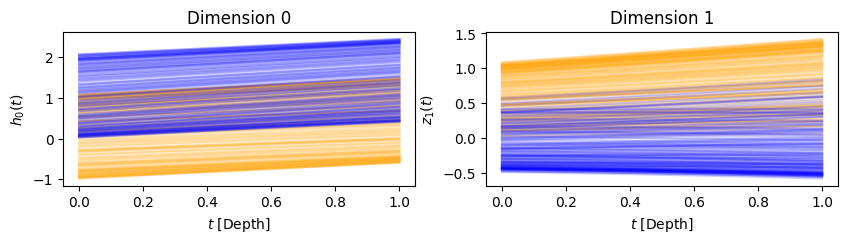

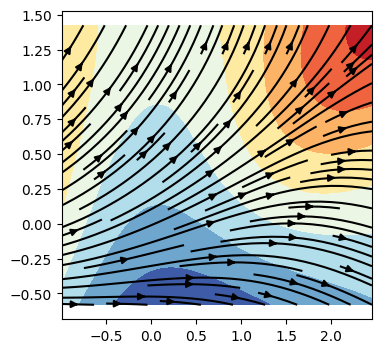

In [38]:
vizualizeNeuralODE(model, X_train)


### Train

properly utilize tensor cores??  set `torch.set_float32_matmul_precision('medium' | 'high')`

In [41]:
# quick run for automated notebook validation
dry_run = False

import os
# Set an environment variable
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# train the model
f2 = nn.Sequential(
        nn.Linear(2, 16),
        nn.Tanh(),
        nn.Linear(16, 2)
    )
t_span = torch.linspace(0,1,100)
model2 = NeuralODE(f2, sensitivity='adjoint', solver='rk4', solver_adjoint='dopri5', atol_adjoint=1e-4, rtol_adjoint=1e-4).to(device)
learn = Learner(t_span, model2)
if dry_run: trainer = L.Trainer(accelerator="gpu", devices=1, min_epochs=1, max_epochs=1)
else: trainer = L.Trainer(accelerator="gpu", min_epochs=200, max_epochs=300, log_every_n_steps=1)
trainer.fit(model=learn, train_dataloaders=trainloader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | NeuralODE | 82     | train
--------------------------------------------
82        Trainable params
0         Non-trainable params
82        Total params
0.000     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Training: |          | 0/? [00:00<?, ?it/s]

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/amr/.local/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/home/amr/.local/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/amr/.local/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/amr/.local/lib/python3.10/site-packages/torch/utils/data/dataset.py", line 211, in __getitem__
    return tuple(tensor[index] for tensor in self.tensors)
  File "/home/amr/.local/lib/python3.10/site-packages/torch/utils/data/dataset.py", line 211, in <genexpr>
    return tuple(tensor[index] for tensor in self.tensors)
RuntimeError: CUDA error: initialization error
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



### Vizualize the Trained Model

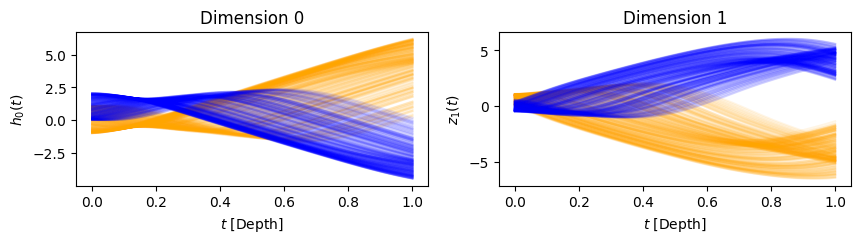

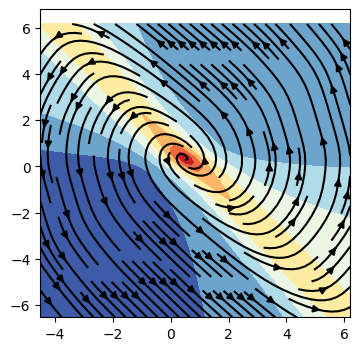

In [25]:
vizualizeNeuralODE(model2, X_train)